
- [Inception V2  from scratch](https://www.kaggle.com/code/phyomyatoo/inception-from-version-2-on-cifar-10/edit)
- 
- 

Inception V1, also known as GoogLeNet, is a deep convolutional neural network that was introduced in 2014. It is known for its "Inception modules" which allow the network to learn features at multiple scales and reduce the number of parameters compared to previous CNN architectures. Building Inception V1 from scratch involves defining convolutional blocks and then assembling them into the Inception modules, which are then combined to create the full network. In this notebook, its building blocks are built from scratch and trained it on CIFAR 10 dataset.

**Notes: Due to small dataset , the model is overfitting.**


In [1]:
import cv2 
import numpy as np
import keras
import tensorflow as tf
from keras.datasets import cifar10 # importing the dataset
from keras import backend as K 
from tensorflow.keras.utils import to_categorical
from keras.layers import Layer
import keras.backend as K
import math 
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D,Dropout, Dense, Input, concatenate,GlobalAveragePooling2D, AveragePooling2D,Flatten
from tensorflow.keras import initializers # Correct way to import initializers
import matplotlib.pyplot as plt
from tensorflow.keras.initializers import HeNormal, Zeros


2025-06-28 05:19:48.233930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751087988.469926      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751087988.526502      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


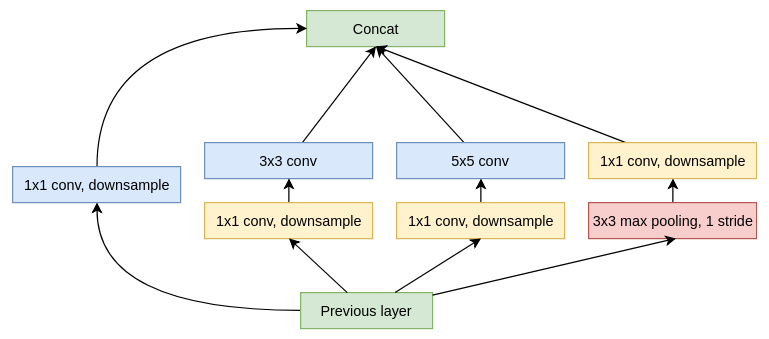
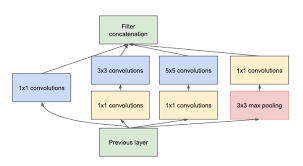
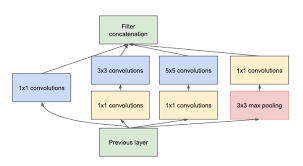
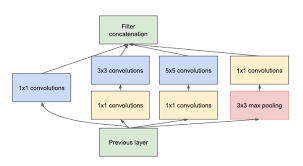
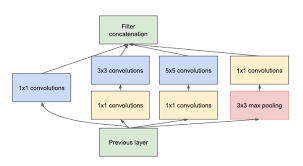
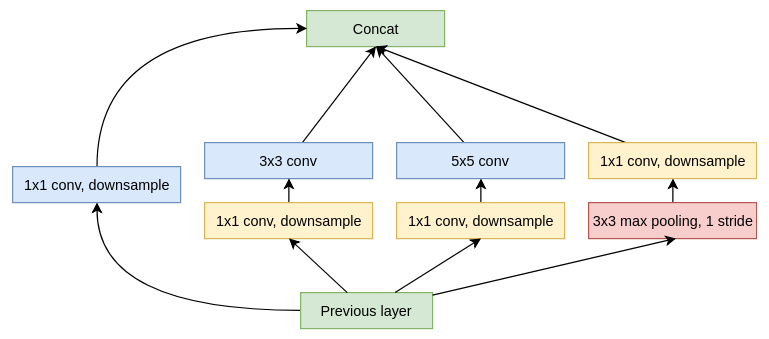

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# CIFAR-10 class labels
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

def cifar10_data(img_rows, img_cols, image_count=500, plot=False):
    # Load training and validation sets
    (X_train, Y_train), (X_valid, Y_valid) = cifar10.load_data()
    
    # Resize images so it fit the 
    X_train = np.array([cv2.resize(img, (img_rows, img_cols)) for img in X_train[:image_count]])
    X_valid = np.array([cv2.resize(img, (img_rows, img_cols)) for img in X_valid[:image_count]])

    # Slice labels
    Y_train = Y_train[:image_count]
    Y_valid = Y_valid[:image_count]

    # One-hot encode labels
    Y_train_cat = to_categorical(Y_train, 10)
    Y_valid_cat = to_categorical(Y_valid, 10)

    # Normalize
    X_train = X_train.astype('float32') / 255.0
    X_valid = X_valid.astype('float32') / 255.0

    # Optional: plot grid of images
    if plot:
        _plot_image_grid(X_train, Y_train)

    return X_train, Y_train, Y_train_cat, X_valid, Y_valid, Y_valid_cat

def _plot_image_grid(X, y, W_grid=10, L_grid=10):
    fig, axes = plt.subplots(L_grid, W_grid, figsize=(17, 17))
    axes = axes.ravel()
    n_images = X.shape[0]

    for i in range(W_grid * L_grid):
        index = np.random.randint(0, n_images)
        image = X[index]
        label_index = y[index][0] if len(y[index].shape) > 0 else y[index]
        axes[i].imshow(image)
        axes[i].set_title(labels[label_index], fontsize=8)
        axes[i].axis('off')

    plt.subplots_adjust(hspace=0.5)
    plt.show()


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


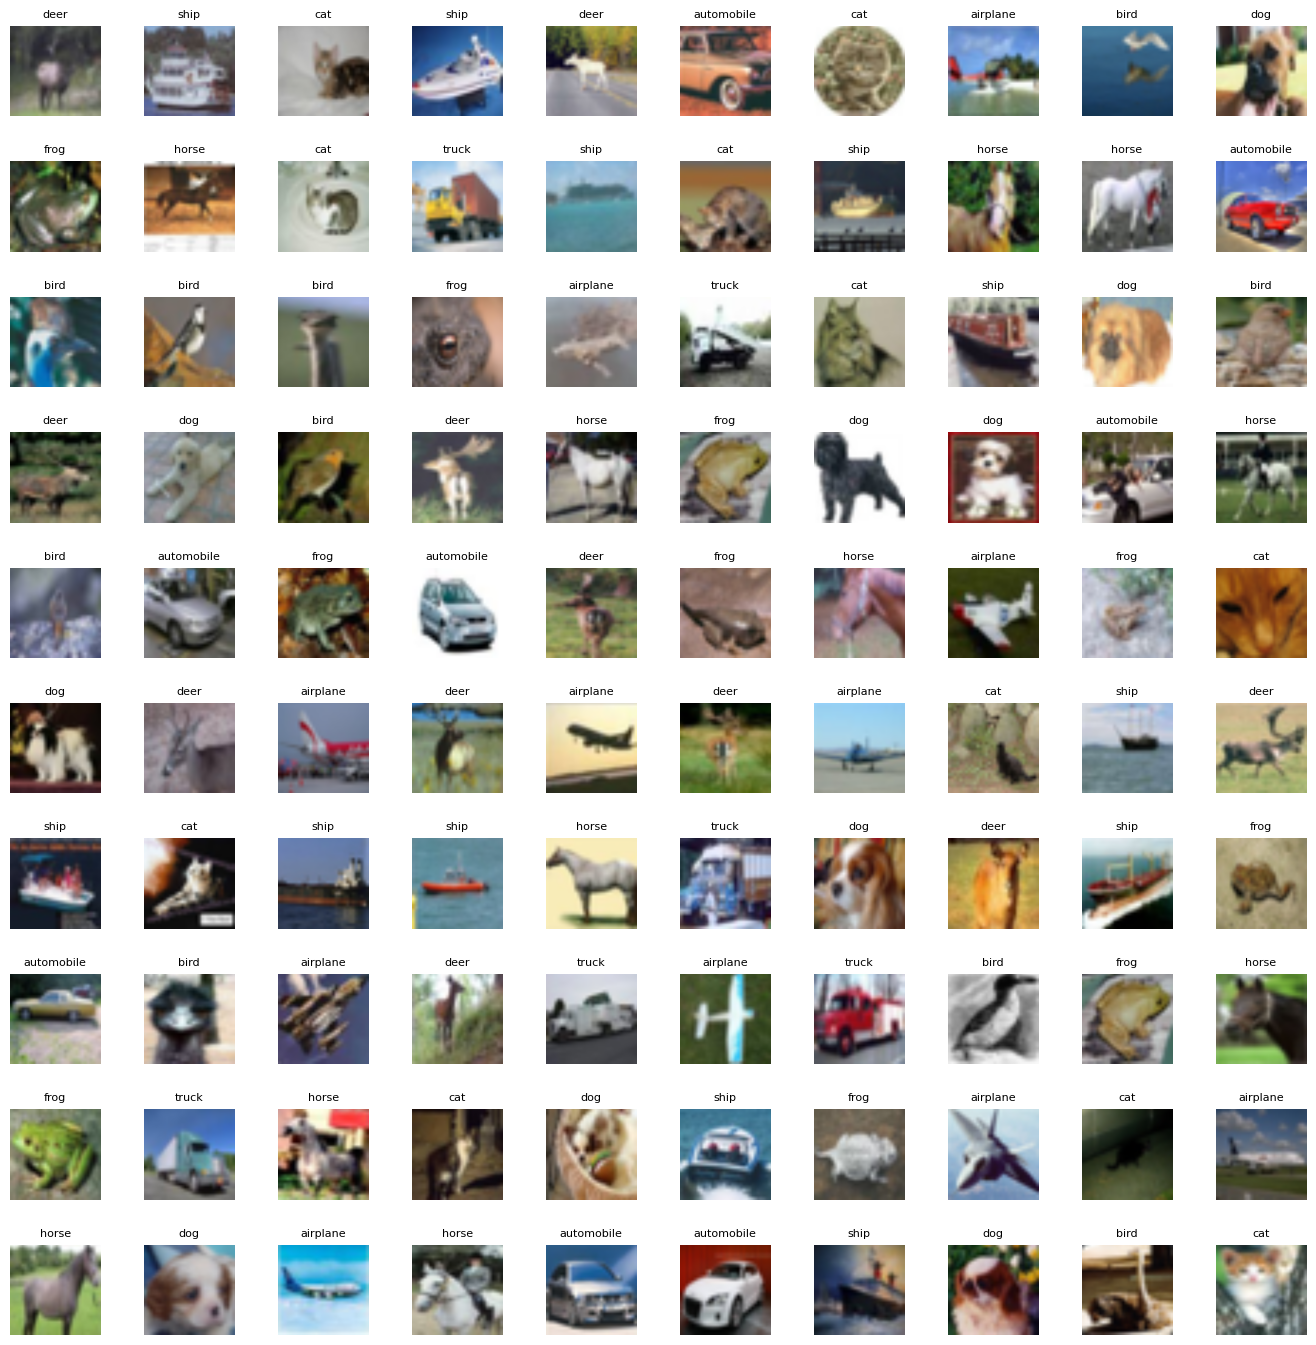

In [3]:
X_train, Y_train, Y_train_cat, X_valid, Y_valid, Y_valid_cat = cifar10_data(
    img_rows=224, img_cols=224, image_count=8000, plot=True
)


In [4]:
print(X_train.shape)  
print(Y_train.shape) 
print(Y_train[0])     


(8000, 224, 224, 3)
(8000, 1)
[6]


In [5]:


kernel_init = HeNormal()
bias_init = Zeros()

def inception_module(x, filters_1x1, filters_3x3_reduce, filters_3x3,
                     filters_5x5_reduce, filters_5x5, filters_pool_proj, name=None):
    
    conv_1x1 = Conv2D(filters_1x1, (1, 1), padding='same', activation='relu',
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(x)

    conv_3x3 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation='relu',
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    
    conv_3x3 = Conv2D(filters_3x3, (3, 3), padding='same', activation='relu',
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_3x3)

    conv_5x5 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation='relu',
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(x)
    conv_5x5 = Conv2D(filters_5x5, (5, 5), padding='same', activation='relu',
                      kernel_initializer=kernel_init, bias_initializer=bias_init)(conv_5x5)

    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters_pool_proj, (1, 1), padding='same', activation='relu',
                       kernel_initializer=kernel_init, bias_initializer=bias_init)(pool_proj)

    output = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=-1, name=name)
    return output







In [6]:
def auxiliary_classifier(x, num_classes, name_suffix):
    aux = AveragePooling2D((5, 5), strides=(3, 3))(x)
    aux = Conv2D(128, (1, 1), padding='same', activation='relu')(aux)
    aux = Flatten()(aux)
    aux = Dense(1024, activation='relu')(aux)
    aux = Dropout(0.7)(aux)
    aux = Dense(num_classes, activation='softmax', name=f'aux_output_{name_suffix}')(aux)
    return aux


In [7]:
#local_rsponse_norm is rarely used now due to slowness
def lrn(x, depth_radius=5, bias=2.0, alpha=1e-4, beta=0.75):
    return tf.nn.local_response_normalization(x, depth_radius, bias, alpha, beta)


In [8]:
def create_inception_v1(input_shape=(224, 224, 3), num_classes=10):
    input_layer = Input(shape=input_shape)

    # Stem
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
    x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
 
    #(INPUT,filters_1x1, filters_3x3_reduce, filters_3x3, filters_5x5_reduce, filters_5x5, filters_pool_proj, name=None):
    
    # Inception modules (from original paper)
    x = inception_module(x, 64, 96, 128, 16, 32, 32, name='inception_3a')
    x = inception_module(x, 128, 128, 192, 32, 96, 64, name='inception_3b')
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 192, 96, 208, 16, 48, 64, name='inception_4a')
    aux1 = auxiliary_classifier(x, num_classes, name_suffix='1')

    x = inception_module(x, 160, 112, 224, 24, 64, 64, name='inception_4b')
    x = inception_module(x, 128, 128, 256, 24, 64, 64, name='inception_4c')
    x = inception_module(x, 112, 144, 288, 32, 64, 64, name='inception_4d')
    aux2 = auxiliary_classifier(x, num_classes, name_suffix='2')

    x = inception_module(x, 256, 160, 320, 32, 128, 128, name='inception_4e')
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = inception_module(x, 256, 160, 320, 32, 128, 128, name='inception_5a')
    x = inception_module(x, 384, 192, 384, 48, 128, 128, name='inception_5b')

    # Final classification
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    output = Dense(num_classes, activation='softmax', name='main_output')(x)

    model = Model(inputs=input_layer, outputs=[output, aux1, aux2], name='inception_v1')
    return model

In [9]:
model = create_inception_v1(input_shape=(224, 224, 3), num_classes=10)
model.summary()


I0000 00:00:1751088019.506776      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "inception_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 64)   │          9,472 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 64)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 64)     │          4,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 56, 56, 192)    │        110,784 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 28, 28, 192)    │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 28, 28, 96)     │         18,528 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 28, 28, 16)     │          3,088 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 28, 28, 192)    │              0 │ max_pooling2d_1[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 28, 28, 64)     │         12,352 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 28, 28, 128)    │        110,720 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 28, 28, 32)     │         12,832 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 28, 28, 32)     │          6,176 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_3a              │ (None, 28, 28, 256)    │              0 │ conv2d_3[0][0],        │
│ (Concatenate)             │                        │                │ conv2d_5[0][0],        │
│                           │                        │                │ conv2d_7[0][0],        │
│                           │                        │                │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 28, 28, 128)    │         32,896 │ inception_3a[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 28, 28, 32)     │          8,224 │ inception_3a[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3      

 Total params: 10,334,030 (39.42 MB)

 Trainable params: 10,334,030 (39.42 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
epochs=20
initial_lrate=0.01
def decay(epoch,steps=100):
    inital_lrate=0.01
    drop=0.96
    epochs_drop=8
    lrate=initial_lrate*math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate

sgd=SGD(learning_rate=initial_lrate,momentum=0.9,nesterov=False)
lr_sc=LearningRateScheduler(decay,verbose=1)
model.compile(loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy'],
             loss_weights=[1,0.3,0.3],optimizer=sgd,metrics=['accuracy','accuracy','accuracy'])

In [11]:
H = model.fit(X_train, [Y_train_cat, Y_train_cat, Y_train_cat],validation_data=(X_valid, [Y_valid_cat, Y_valid_cat, Y_valid_cat]), epochs=epochs, batch_size=64, callbacks=[lr_sc])



Epoch 1: LearningRateScheduler setting learning rate to 0.01.
Epoch 1/20


I0000 00:00:1751088044.932561      99 service.cc:148] XLA service 0x7af130001fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751088044.933200      99 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751088046.149392      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1:12:19 35s/step - aux_output_1_accuracy: 0.1250 - aux_output_1_loss: 2.2938 - aux_output_2_accuracy: 0.1406 - aux_output_2_loss: 2.2965 - loss: 3.6993 - main_output_accuracy: 0.0625 - main_output_loss: 2.3222

I0000 00:00:1751088067.836768      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


125/125 ━━━━━━━━━━━━━━━━━━━━ 74s 317ms/step - aux_output_1_accuracy: 0.1187 - aux_output_1_loss: 2.2919 - aux_output_2_accuracy: 0.1207 - aux_output_2_loss: 2.2908 - loss: 3.6598 - main_output_accuracy: 0.1127 - main_output_loss: 2.2849 - val_aux_output_1_accuracy: 0.2278 - val_aux_output_1_loss: 2.1130 - val_aux_output_2_accuracy: 0.2155 - val_aux_output_2_loss: 2.1293 - val_loss: 3.4498 - val_main_output_accuracy: 0.1884 - val_main_output_loss: 2.1772 - learning_rate: 0.0100

Epoch 2: LearningRateScheduler setting learning rate to 0.01.
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 166ms/step - aux_output_1_accuracy: 0.2042 - aux_output_1_loss: 2.1271 - aux_output_2_accuracy: 0.2108 - aux_output_2_loss: 2.1383 - loss: 3.4199 - main_output_accuracy: 0.1998 - main_output_loss: 2.1403 - val_aux_output_1_accuracy: 0.2784 - val_aux_output_1_loss: 1.9677 - val_aux_output_2_accuracy: 0.2834 - val_aux_output_2_loss: 1.9816 - val_loss: 3.3217 - val_main_output_accuracy: 0.2013 - val_main_output


--- Model Evaluation ---
Validation Total Loss: 1.7458
Validation Main Output Loss: 1.0938
Validation Auxiliary 1 Output Loss: 1.1040
Validation Auxiliary 2 Output Loss: 1.0695
Validation Main Output Accuracy: 60.18%
Validation Auxiliary 1 Output Accuracy: 61.87%
Validation Auxiliary 2 Output Accuracy: 61.86%


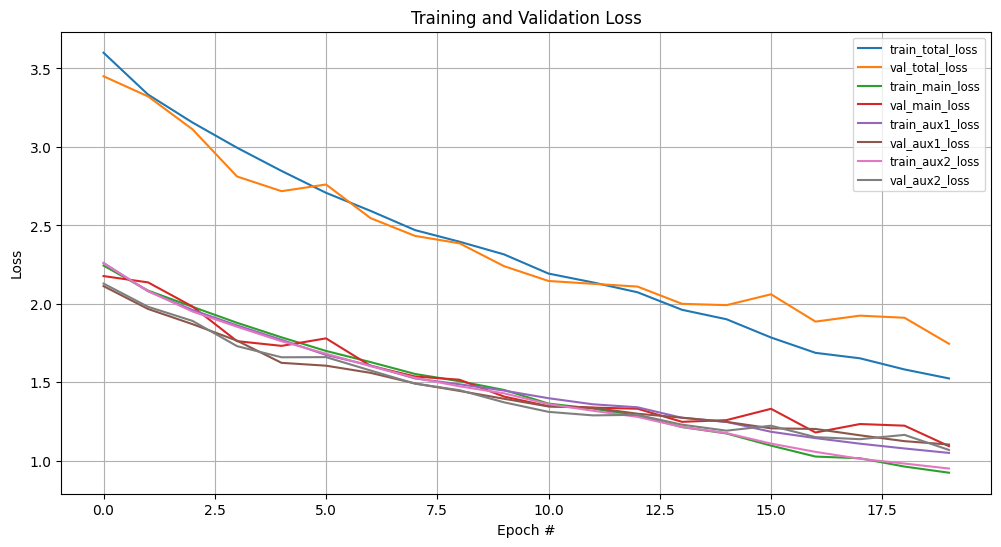

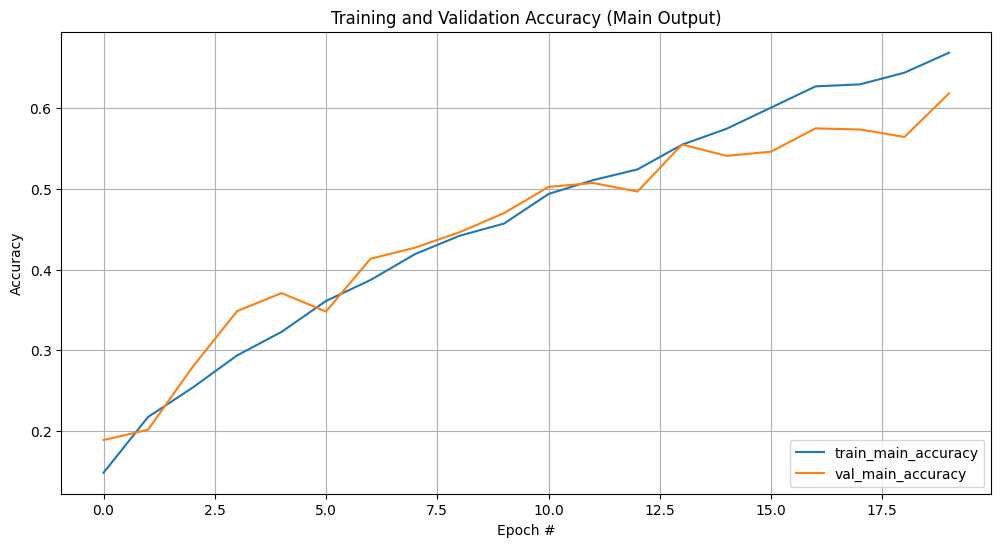

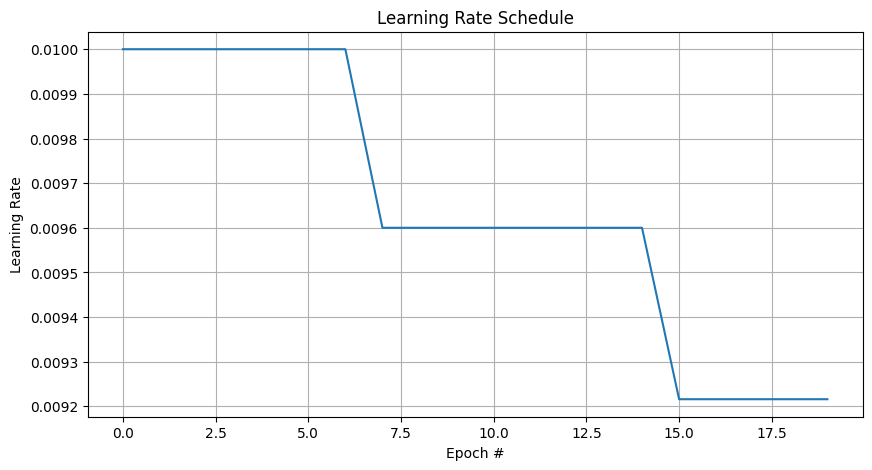

In [13]:
### Evaluation and Plotting ###

# Evaluate the model on the validation set
print("\n--- Model Evaluation ---")
results = model.evaluate(X_valid, [Y_valid_cat, Y_valid_cat, Y_valid_cat], verbose=0)

# The 'results' list will contain [total_loss, main_output_loss, aux1_loss, aux2_loss,
#                                  main_output_accuracy, aux1_accuracy, aux2_accuracy]
# corresponding to the order in which losses and metrics were compiled.
# Assuming the order from model.compile:
# loss=['categorical_crossentropy','categorical_crossentropy','categorical_crossentropy']
# metrics=['accuracy','accuracy','accuracy']
# So the order will be: total_loss, main_loss, aux1_loss, aux2_loss, main_acc, aux1_acc, aux2_acc

print(f"Validation Total Loss: {results[0]:.4f}")
print(f"Validation Main Output Loss: {results[1]:.4f}")
print(f"Validation Auxiliary 1 Output Loss: {results[2]:.4f}")
print(f"Validation Auxiliary 2 Output Loss: {results[3]:.4f}")
print(f"Validation Main Output Accuracy: {results[4]*100:.2f}%")
print(f"Validation Auxiliary 1 Output Accuracy: {results[5]*100:.2f}%")
print(f"Validation Auxiliary 2 Output Accuracy: {results[6]*100:.2f}%")


# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(np.arange(0, epochs), H.history['loss'], label='train_total_loss')
plt.plot(np.arange(0, epochs), H.history['val_loss'], label='val_total_loss')
plt.plot(np.arange(0, epochs), H.history['main_output_loss'], label='train_main_loss')
plt.plot(np.arange(0, epochs), H.history['val_main_output_loss'], label='val_main_loss')
plt.plot(np.arange(0, epochs), H.history['aux_output_1_loss'], label='train_aux1_loss')
plt.plot(np.arange(0, epochs), H.history['val_aux_output_1_loss'], label='val_aux1_loss')
plt.plot(np.arange(0, epochs), H.history['aux_output_2_loss'], label='train_aux2_loss')
plt.plot(np.arange(0, epochs), H.history['val_aux_output_2_loss'], label='val_aux2_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend(loc='upper right', fontsize='small')
plt.grid(True)
plt.show()

# Plotting training and validation accuracy for the main output
plt.figure(figsize=(12, 6))
plt.plot(np.arange(0, epochs), H.history['main_output_accuracy'], label='train_main_accuracy')
plt.plot(np.arange(0, epochs), H.history['val_main_output_accuracy'], label='val_main_accuracy')
plt.title('Training and Validation Accuracy (Main Output)')
plt.xlabel('Epoch #')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plotting learning rate schedule
plt.figure(figsize=(10, 5))
plt.plot(np.arange(0, epochs), H.history['learning_rate'])
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch #')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()
